In [ ]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas
import xarray
import h5py
import random

from matplotlib import pyplot as plt
import seaborn as sns

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting

# LLC Outputs & MODIS Data

In [ ]:
os.getenv('ENDPOINT_URL') 
tbl_file = 's3://llc/Tables/test_noise_modis2012.parquet'
llc_table = ulmo_io.load_main_table(tbl_file)
new_tbl_file = 's3://modis-l2/Tables/MODIS_L2_std.parquet'
mod_table = ulmo_io.load_main_table(new_tbl_file)
tbl_file1 = 's3://llc/Tables/test_modis2012.parquet'
llc_wo_noise = ulmo_io.load_main_table(tbl_file1)

In [3]:
llc_table.head()

,modis_lat,modis_lon,modis_col,modis_datetime,modis_LL,modis_row,clear_fraction,mean_temperature,Tmin,Tmax,...,field_size,pp_type,pp_idx,lat,lon,row,col,datetime,filename,LL
0,-52.410507,-42.126858,1028,2012-01-01 04:10:00,-147.370605,64,0.049805,4.124990,3.401999,6.411,...,64,0,487936,-52.406319,-42.135418,4687,17049,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,124.020691
1,-52.194720,-42.787216,997,2012-01-01 04:10:00,-248.946106,48,0.043213,5.315350,3.464000,6.544,...,64,0,517068,-52.188812,-42.781250,4705,17018,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,45.473206
2,-52.031720,-43.191420,976,2012-01-01 04:10:00,-264.156342,33,0.049500,5.912542,3.557000,6.852,...,64,0,58066,-52.031147,-43.197918,4718,16998,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,159.249695
3,-51.908875,-42.702328,997,2012-01-01 04:10:00,-228.816925,16,0.018188,5.859069,3.442000,6.709,...,64,0,76355,-51.909538,-42.697918,4728,17022,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,153.434143
4,-51.865665,-43.186947,974,2012-01-01 04:10:00,-260.829315,16,0.048279,6.131550,5.386000,6.852,...,64,0,523013,-51.860813,-43.177082,4732,16999,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,148.887573


#### Create columns needed for analysis

In [4]:
llc_table['DT'] = llc_table['T90'] - llc_table['T10']

In [5]:
mod_table['DT'] = mod_table['T90'] - mod_table['T10']

In [6]:
llc_wo_noise['DT'] = llc_wo_noise['T90'] - llc_wo_noise['T10']

In [7]:
llc_table.shape[0]

635295

In [8]:
llc_wo_noise.shape

(635295, 27)

#### Create year 2012 table for MODIS

In [9]:
year_2012 = mod_table[(mod_table.datetime >= pandas.to_datetime('2012-01-01 00:00:00')) & (mod_table.datetime < pandas.to_datetime('2012-11-15 11:35:00'))]

In [10]:
year_2012.shape

(647744, 20)

#### Grabbing top and bottom 1% of LLC and MODIS

In [18]:
#low LL
LL99 = np.percentile(llc_table.LL.to_numpy(), 99.9)
LL1 = np.percentile(llc_table.LL.to_numpy(), 0.1)

LL99_M = np.percentile(year_2012.LL.to_numpy(), 99.9)
LL1_M = np.percentile(year_2012.LL.to_numpy(), 0.1)

lowLL_LLC = llc_table[llc_table.LL < LL1]

lowLL_MOD = year_2012[year_2012.LL < LL1_M]

#high LL
highLL_LLC = llc_table[llc_table.LL > LL99]

highLL_MOD = year_2012[year_2012.LL > LL99_M]

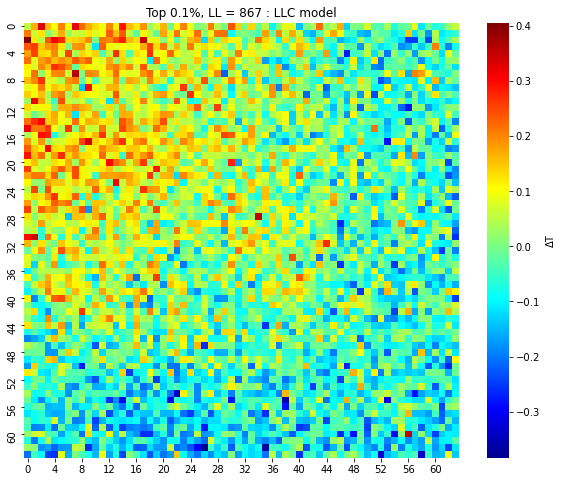

In [41]:
# LLC top 0.1% image
_, cm = ulmo_plotting.load_palette()

cutout = highLL_LLC.iloc[20]

img = llc_io.grab_image(cutout)

fig = plt.figure( figsize = (10, 8))
ax = fig.add_subplot(1,1,1)
ax = sns.heatmap(np.flipud(img), xticklabels=4, yticklabels=4, cmap=cm, cbar=True, square = True,
                 cbar_kws={'label': r'$\Delta$T'})
ax.set_title('Top 0.1%, LL = {} : LLC model'.format( round(cutout.LL)), fontsize = 12)
plt.show()

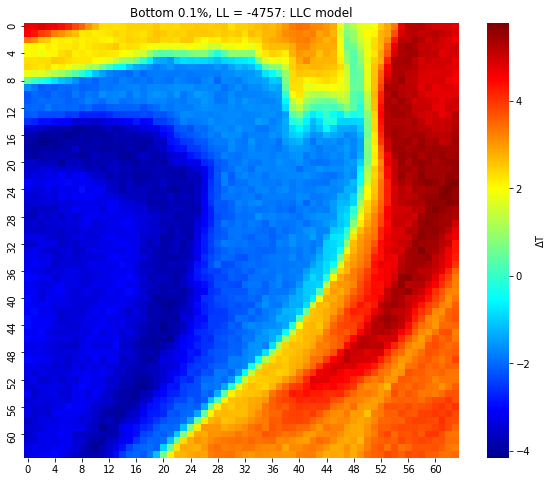

In [39]:
# LLC bottom 0.1% image
_, cm = ulmo_plotting.load_palette()

cutout = lowLL_LLC.iloc[20]

img = llc_io.grab_image(cutout)

fig = plt.figure( figsize = (10, 8))
ax = fig.add_subplot(1,1,1)
ax = sns.heatmap(np.flipud(img), xticklabels=4, yticklabels=4, cmap=cm, cbar=True, square = True,
                 cbar_kws={'label': r'$\Delta$T'})
ax.set_title('Bottom 0.1%, LL = {}: LLC model'.format( round( cutout.LL)) , fontsize = 12)
plt.show()

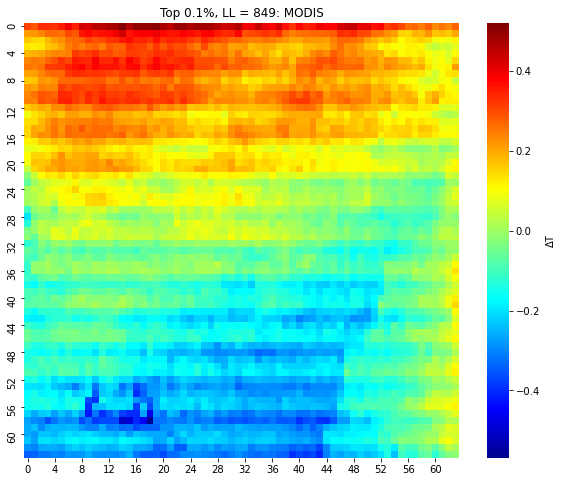

In [40]:
# MODIS top 1% image
_, cm = ulmo_plotting.load_palette()

cutout = highLL_MOD.iloc[20]

img = llc_io.grab_image(cutout)

fig = plt.figure( figsize = (10, 8))
ax = fig.add_subplot(1,1,1)
ax = sns.heatmap(np.flipud(img), xticklabels=4, yticklabels=4, cmap=cm, cbar=True, square = True,
                 cbar_kws={'label': r'$\Delta$T'})
ax.set_title('Top 0.1%, LL = {}: MODIS'.format( round(cutout.LL)), fontsize = 12)
plt.show()

In [24]:
cutout

lat                                                          7.221989
lon                                                         -20.02607
col                                                               421
datetime                                          2012-01-27 02:50:00
LL                                                         848.524536
row                                                               848
clear_fraction                                                    0.0
mean_temperature                                            27.114975
Tmin                                                        26.059999
Tmax                                                           27.775
T90                                                         27.394999
T10                                                            26.855
filename                         AQUA_MODIS.20120127T025008.L2.SST.nc
UID                                                132797222015997393
pp_file             

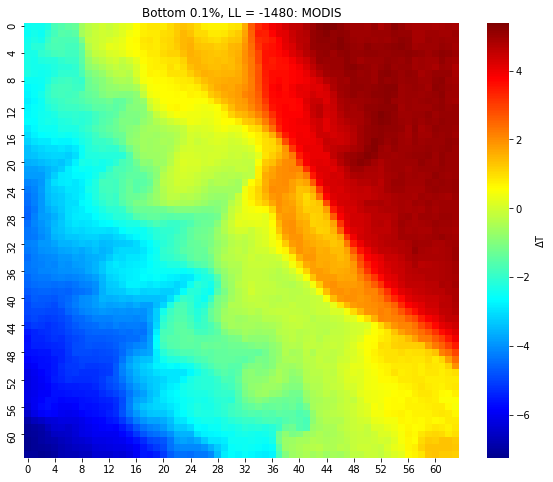

In [43]:
# MODIS bottom 1% image
_, cm = ulmo_plotting.load_palette()

cutout = lowLL_MOD.iloc[20]

img = llc_io.grab_image(cutout)

fig = plt.figure( figsize = (10, 8))
ax = fig.add_subplot(1,1,1)
ax = sns.heatmap(np.flipud(img), xticklabels=4, yticklabels=4, cmap=cm, cbar=True, square = True,
                 cbar_kws={'label': r'$\Delta$T'})
ax.set_title('Bottom 0.1%, LL = {}: MODIS'.format(round(cutout.LL)), fontsize = 12)
plt.show()

#### LL Histogram

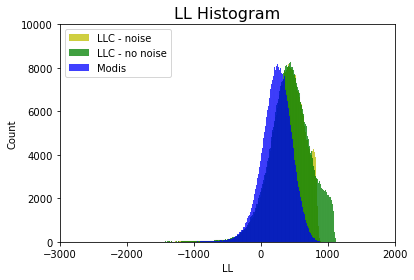

In [102]:
# Give histplot the dataframe and the column name
ax = sns.histplot(data= llc_table, x='LL', color = 'y', stat = 'count', label = 'LLC - noise')
ax = sns.histplot(data= llc_wo_noise, x='LL', color = 'g', stat = 'count', label = 'LLC - no noise')
ax = sns.histplot(data= year_2012, x='LL', color = 'b', stat = 'count', label = 'Modis')

ax.set_xlim(-3000., 2000.)
ax.set_ylim(0., 10000)
ax.set_title('LL Histogram', fontsize = 16)
ax.legend()

#### Mean T Histogram

(0.0, 0.2)

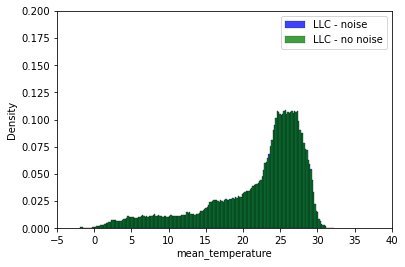

In [49]:
# Give histplot the dataframe and the column name
ax_t = sns.histplot(data= llc_table, x='mean_temperature', color = 'b', stat = 'density', label = 'LLC - noise')
ax_t = sns.histplot(data= llc_wo_noise, x='mean_temperature', color = 'g', stat = 'density', label = 'LLC - no noise')
#ax_t = sns.histplot(data= mod_table, x='mean_temperature', color = 'g', stat = 'density', label = 'MODIS')

ax_t.legend()
ax_t.set_xlim(-5., 40.)
ax_t.set_ylim(0., 0.2)

#### DT Histogram

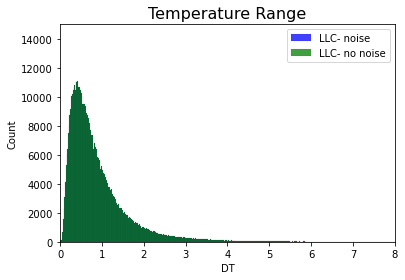

In [51]:
ax_dt = sns.histplot(data= llc_table, x='DT', color = 'b', stat = 'count', label = 'LLC- noise')
ax_dt = sns.histplot(data= llc_wo_noise, x='DT', color = 'g', stat = 'count', label = 'LLC- no noise')
#ax_dt = sns.histplot(data= year_2012, x='DT', color = 'g', stat = 'count', label = 'MODIS')

ax_dt.set_xlim(0., 8.)
ax_dt.set_ylim(0., 15000)
ax_dt.set_title('Temperature Range', fontsize = 16)
ax_dt.legend()


# Zone 1: Equatorial Pacific

In [52]:
in_pacific = (llc_table.lon > -180.) & (llc_table.lon < -80.)
near_equator = (llc_table.lat > -10) & (llc_table.lat < 10)

#zone 1
zone1 = llc_table[in_pacific & near_equator]

In [53]:
in_pacific = (year_2012.lon > -180.) & (year_2012.lon < -80.)
near_equator = (year_2012.lat > -10) & (year_2012.lat < 10)

#zone 1
zone1_M = year_2012[in_pacific & near_equator]

In [60]:
in_pacific = (llc_wo_noise.lon > -180.) & (llc_wo_noise.lon < -80.)
near_equator = (llc_wo_noise.lat > -10) & (llc_wo_noise.lat < 10)

#zone 1
zone1_N = llc_wo_noise[in_pacific & near_equator]

In [61]:
#low LL
LL99 = np.percentile(zone1.LL.to_numpy(), 99)
LL1 = np.percentile(zone1.LL.to_numpy(), 1)

LL99_M = np.percentile(zone1_M.LL.to_numpy(), 99)
LL1_M = np.percentile(zone1_M.LL.to_numpy(), 1)

lowLL_zone1 = zone1[zone1.LL < LL1]

lowLL_zone1_M = zone1_M[zone1_M.LL < LL1_M]

#high LL
highLL_zone1 = zone1[zone1.LL > LL99]

highLL_zone1_M = zone1_M[zone1_M.LL > LL99_M]

In [62]:
zone1.head()

,modis_lat,modis_lon,modis_col,modis_datetime,modis_LL,modis_row,clear_fraction,mean_temperature,Tmin,Tmax,...,pp_type,pp_idx,lat,lon,row,col,datetime,filename,LL,DT
202,-7.891554,-109.553930,773,2012-01-01 08:50:00,403.138611,1862,0.048767,23.619480,23.490002,23.875999,...,0,128328,-7.898280,-109.552086,7477,13813,2012-01-01 12:00:00,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T12_00_...,804.823853,0.167000
203,-7.872714,-109.619430,766,2012-01-01 08:50:00,397.708374,1861,0.049927,23.627960,23.496000,23.889999,...,0,623684,-7.879214,-109.614586,7478,13810,2012-01-01 12:00:00,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T12_00_...,839.105530,0.184999
204,-7.810381,-109.409065,786,2012-01-01 08:50:00,318.722900,1851,0.049866,23.633785,23.477001,23.889999,...,0,119068,-7.802940,-109.406250,7482,13820,2012-01-01 12:00:00,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T12_00_...,811.312988,0.252998
205,-7.471281,-133.539080,837,2012-01-01 10:30:00,263.785706,1352,0.048828,25.152061,24.768002,25.511002,...,0,66035,-7.478584,-133.531250,7499,12662,2012-01-01 12:00:00,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T12_00_...,441.100220,0.470999
206,-7.459239,-133.869050,805,2012-01-01 10:30:00,258.507568,1356,0.048828,25.136745,24.768002,25.538002,...,0,297801,-7.459495,-133.864578,7500,12646,2012-01-01 12:00:00,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T12_00_...,447.893433,0.458000


In [63]:
zone1.iloc[0].filename

's3://llc/ThetaUVSalt/LLC4320_2012-01-01T12_00_00.nc'

#### Location

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


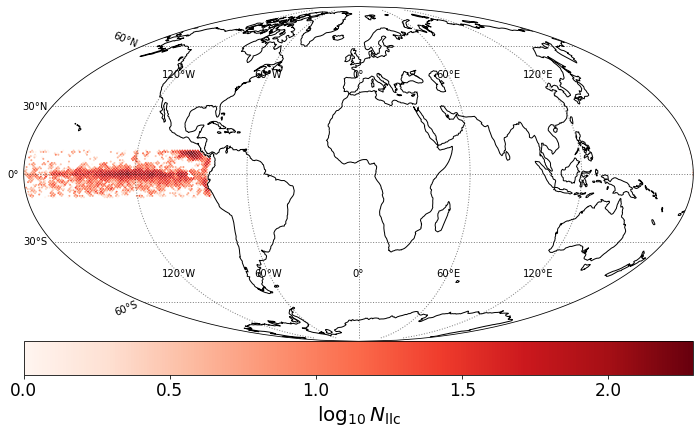

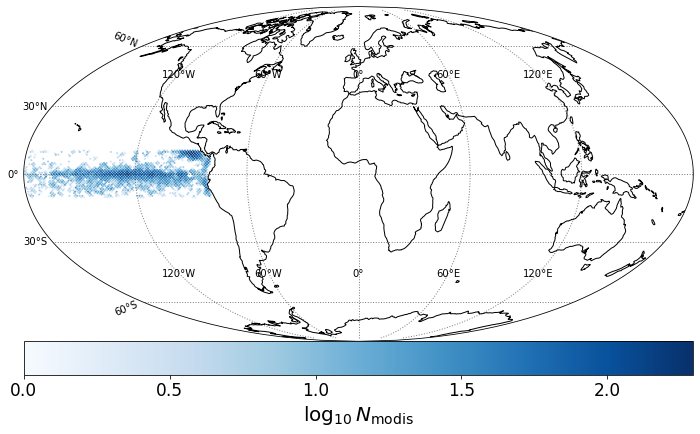

In [64]:
_ = ulmo_figs.show_spatial(zone1, lbl = 'llc')
_ = ulmo_figs.show_spatial(zone1_M, lbl = 'modis', color = 'Blues')

#### LL Histogram

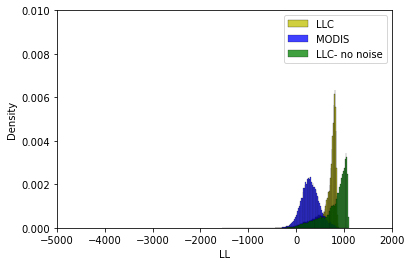

In [101]:
# Give histplot the dataframe and the column name
ax1 = sns.histplot(data=zone1, x='LL', color = 'y', stat = 'density', label = 'LLC')
ax1 = sns.histplot(data=zone1_M, x='LL', color = 'b', stat = 'density', label = 'MODIS')
ax1 = sns.histplot(data=zone1_N, x='LL', color = 'g', stat = 'density', label = 'LLC- no noise')

ax1.set_xlim(-5000., 2000.)
ax1.set_ylim(0., 0.01)
ax1.legend()

#### Mean T Histogram

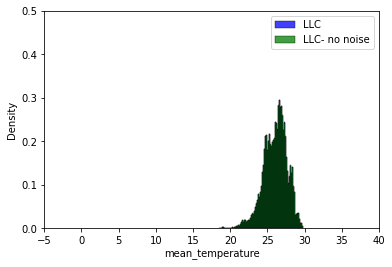

In [66]:
ax1_t = sns.histplot(data= zone1, x='mean_temperature', color = 'b', stat = 'density', label = 'LLC')
#ax1_t = sns.histplot(data=zone1_M, x='mean_temperature', color = 'g', stat = 'density', label = 'MODIS')
ax1_t = sns.histplot(data=zone1_N, x='mean_temperature', color = 'g', stat = 'density', label = 'LLC- no noise')

ax1_t.set_xlim(-5., 40.)
ax1_t.set_ylim(0., 0.5)
ax1_t.legend()

#### DT Histogram

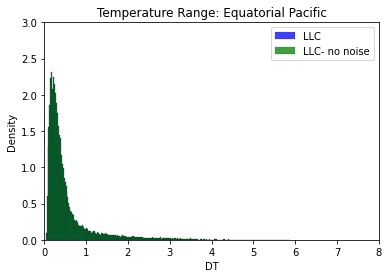

In [67]:
ax1_dt = sns.histplot(data= zone1, x='DT', color = 'b', stat = 'density', label = 'LLC')
#ax1_dt = sns.histplot(data=zone1_M, x='DT', color = 'g', stat = 'density', label = 'MODIS')
ax1_dt = sns.histplot(data=zone1_N, x='DT', color = 'g', stat = 'density', label = 'LLC- no noise')

ax1_dt.set_xlim(0., 8.)
ax1_dt.set_ylim(0., 3)
ax1_dt.set_title('Temperature Range: Equatorial Pacific')
ax1_dt.legend()

# Zone 2: Indian Ocean

In [68]:
in_indian = (llc_table.lon > 50.) & (llc_table.lon < 90.)
near_equator1 = (llc_table.lat > -15) & (llc_table.lat < 10)

#zone 2
zone2 = llc_table[in_indian & near_equator1]

In [69]:
in_indian = (year_2012.lon > 50.) & (year_2012.lon < 90.)
near_equator1 = (year_2012.lat > -15) & (year_2012.lat < 10)

#zone 2
zone2_M = year_2012[in_indian & near_equator1]

In [70]:
in_indian = (llc_wo_noise.lon > 50.) & (llc_wo_noise.lon < 90.)
near_equator1 = (llc_wo_noise.lat > -15) & (llc_wo_noise.lat < 10)

#zone 2
zone2_N = llc_wo_noise[in_indian & near_equator1]

In [71]:
#low LL
LL99 = np.percentile(zone2.LL.to_numpy(), 99)
LL1 = np.percentile(zone2.LL.to_numpy(), 1)

LL99_M = np.percentile(zone2_M.LL.to_numpy(), 99)
LL1_M = np.percentile(zone2_M.LL.to_numpy(), 1)

lowLL_zone2 = zone2[zone2.LL < LL1]

lowLL_zone2_M = zone2_M[zone2_M.LL < LL1_M]

#high LL
highLL_zone2 = zone2[zone2.LL > LL99]

highLL_zone2_M = zone2_M[zone2_M.LL > LL99_M]

In [72]:
zone2.head()

,modis_lat,modis_lon,modis_col,modis_datetime,modis_LL,modis_row,clear_fraction,mean_temperature,Tmin,Tmax,...,pp_type,pp_idx,lat,lon,row,col,datetime,filename,LL,DT
814,1.758326,75.111374,325,2012-01-01 20:20:00,469.843872,1738,0.049194,28.568413,28.358002,28.726002,...,0,345483,1.750807,75.114586,7978,5397,2012-01-02,s3://llc/ThetaUVSalt/LLC4320_2012-01-02T00_00_...,806.241211,0.238001
815,1.892684,74.758950,292,2012-01-01 20:20:00,437.006531,1729,0.049927,28.508785,28.301001,28.726002,...,0,338236,1.886071,74.760414,7985,5380,2012-01-02,s3://llc/ThetaUVSalt/LLC4320_2012-01-02T00_00_...,756.624207,0.273001
816,1.987317,75.162060,325,2012-01-01 20:20:00,568.424988,1712,0.018494,28.549904,28.365002,28.726002,...,0,233338,1.982672,75.156250,7990,5399,2012-01-02,s3://llc/ThetaUVSalt/LLC4320_2012-01-02T00_00_...,791.800659,0.228001
817,2.039060,74.804000,293,2012-01-01 20:20:00,506.453125,1712,0.026794,28.493784,28.309000,28.726002,...,0,268798,2.040626,74.802086,7993,5382,2012-01-02,s3://llc/ThetaUVSalt/LLC4320_2012-01-02T00_00_...,781.191956,0.264000
818,2.114277,74.428900,261,2012-01-01 20:20:00,436.807739,1710,0.047852,28.425047,28.209002,28.719002,...,0,179805,2.117891,74.427086,7997,5364,2012-01-02,s3://llc/ThetaUVSalt/LLC4320_2012-01-02T00_00_...,766.833679,0.245001


#### Location

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


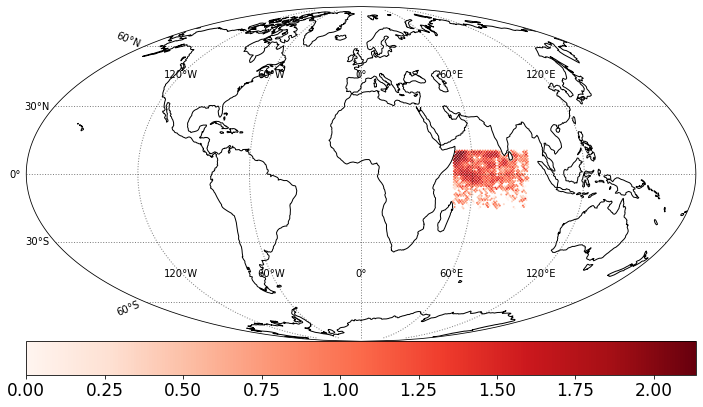

In [22]:
_ = ulmo_figs.show_spatial(zone2)

#### LL Histogram

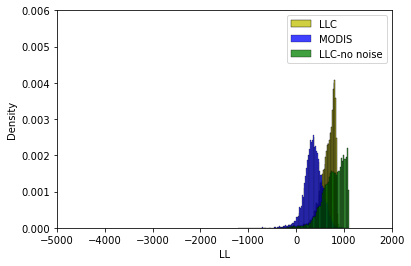

In [103]:
# Give histplot the dataframe and the column name
ax2 = sns.histplot(data= zone2, x='LL', color = 'y', stat = 'density', label = 'LLC')
ax2 = sns.histplot(data=zone2_M, x='LL', color = 'b', stat = 'density', label = 'MODIS')
ax2 = sns.histplot(data=zone2_N, x='LL', color = 'g', stat = 'density', label = 'LLC-no noise')

ax2.set_xlim(-5000., 2000.)
ax2.set_ylim(0., 0.006)
ax2.legend()

#### Mean T Histogram

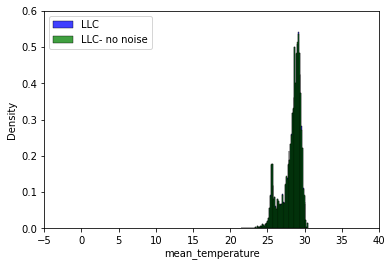

In [74]:
ax2_t = sns.histplot(data= zone2, x='mean_temperature', color = 'b', stat = 'density', label = 'LLC')
#ax2_t = sns.histplot(data=zone2_M, x='mean_temperature', color = 'g', stat = 'density', label = 'MODIS')
ax2_t = sns.histplot(data=zone2_N, x='mean_temperature', color = 'g', stat = 'density', label = 'LLC- no noise')

ax2_t.set_xlim(-5., 40.)
ax2_t.set_ylim(0., 0.6)
ax2_t.legend()

#### DT Histogram

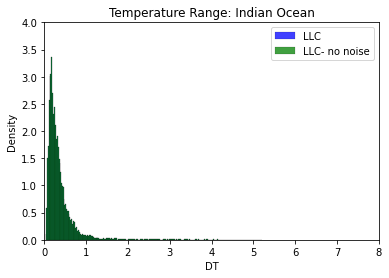

In [75]:
ax2_dt = sns.histplot(data= zone2, x='DT', color = 'b', stat = 'density', label = 'LLC')
#ax2_dt = sns.histplot(data=zone2_M, x='DT', color = 'g', stat = 'density', label = 'MODIS')
ax2_dt = sns.histplot(data=zone2_N, x='DT', color = 'g', stat = 'density', label = 'LLC- no noise')

ax2_dt.set_xlim(0., 8.)
ax2_dt.set_ylim(0., 4)
ax2_dt.set_title('Temperature Range: Indian Ocean')
ax2_dt.legend()

#### Pick 9 random numbers for indices

In [27]:
lowLL_zone2.shape

(166, 27)

In [28]:
highLL_zone2.shape

(166, 27)

In [29]:
indices2 = random.sample( range(lowLL_zone2.shape[0]), 9)

lowLL_2 = lowLL_zone2.iloc[indices2]
highLL_2 = highLL_zone2.iloc[indices2]

# Zone 3: South American East Coast

In [76]:
in_atlantic = (llc_table.lon > -70.) & (llc_table.lon < -40.)
below_equator = (llc_table.lat > -50) & (llc_table.lat < -30)

#zone 3
zone3 = llc_table[in_atlantic & below_equator]

In [77]:
in_atlantic = (year_2012.lon > -70.) & (year_2012.lon < -40.)
below_equator = (year_2012.lat > -50) & (year_2012.lat < -30)

#zone 3
zone3_M = year_2012[in_atlantic & below_equator]

In [78]:
in_atlantic = (llc_wo_noise.lon > -70.) & (llc_wo_noise.lon < -40.)
below_equator = (llc_wo_noise.lat > -50) & (llc_wo_noise.lat < -30)

#zone 3
zone3_N = llc_wo_noise[in_atlantic & below_equator]

In [79]:
#low LL
LL99 = np.percentile(zone3.LL.to_numpy(), 99)
LL1 = np.percentile(zone3.LL.to_numpy(), 1)

LL99_M = np.percentile(zone3_M.LL.to_numpy(), 99)
LL1_M = np.percentile(zone3_M.LL.to_numpy(), 1)

lowLL_zone3 = zone3[zone3.LL < LL1]

lowLL_zone3_M = zone3_M[zone3_M.LL < LL1_M]

#high LL
highLL_zone3 = zone3[zone3.LL > LL99]

highLL_zone3_M = zone3_M[zone3_M.LL > LL99_M]

In [80]:
zone3.head()

,modis_lat,modis_lon,modis_col,modis_datetime,modis_LL,modis_row,clear_fraction,mean_temperature,Tmin,Tmax,...,pp_type,pp_idx,lat,lon,row,col,datetime,filename,LL,DT
5,-43.289627,-52.337948,197,2012-01-01 04:05:00,65.601135,1264,0.037964,19.539640,16.013,21.828001,...,0,256662,-43.294323,-52.343750,5384,16559,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,-342.616089,5.036001
6,-43.301037,-51.702736,229,2012-01-01 04:05:00,-26.248413,1252,0.049805,19.630821,15.885,21.828001,...,0,57049,-43.294323,-51.697918,5384,16590,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,-697.843994,5.167000
7,-43.235897,-51.077957,261,2012-01-01 04:05:00,-33.526733,1232,0.043335,18.088089,15.961,21.560001,...,0,132243,-43.237888,-51.072918,5388,16620,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,-362.451660,4.766003
8,-43.128727,-51.626130,229,2012-01-01 04:05:00,-2.603516,1232,0.014709,19.670353,15.961,21.819000,...,0,227893,-43.124866,-51.635418,5396,16593,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,-470.987854,4.917999
9,-43.053740,-50.444057,293,2012-01-01 04:05:00,46.522583,1200,0.044067,17.223206,16.090,18.121000,...,0,396911,-43.054134,-50.447918,5401,16650,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,172.158142,1.115000


#### Location

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


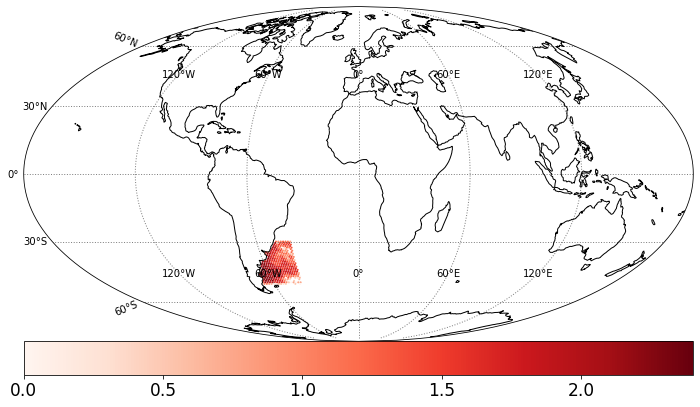

In [35]:
_ = ulmo_figs.show_spatial(zone3)

#### LL Histogram

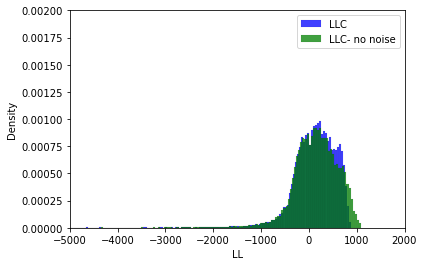

In [81]:
# Give histplot the dataframe and the column name
ax3 = sns.histplot(data= zone3, x='LL', color = 'b', stat = 'density', label = 'LLC')
#ax3 = sns.histplot(data=zone3_M, x='LL', color = 'g', stat = 'density', label = 'MODIS')
ax3 = sns.histplot(data=zone3_N, x='LL', color = 'g', stat = 'density', label = 'LLC- no noise')

ax3.set_xlim(-5000., 2000.)
ax3.set_ylim(0., 0.002)
ax3.legend()

#### Mean T Histogram

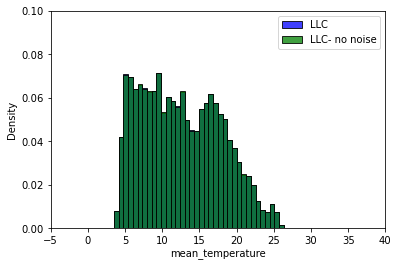

In [82]:
ax3_t = sns.histplot(data= zone3, x='mean_temperature', color = 'b', stat = 'density', label = 'LLC')
#ax3_t = sns.histplot(data=zone3_M, x='mean_temperature', color = 'g', stat = 'density', label = 'MODIS')
ax3_t = sns.histplot(data=zone3_N, x='mean_temperature', color = 'g', stat = 'density', label = 'LLC- no noise')

ax3_t.set_xlim(-5., 40.)
ax3_t.set_ylim(0., 0.1)
ax3_t.legend()

#### DT Histogram

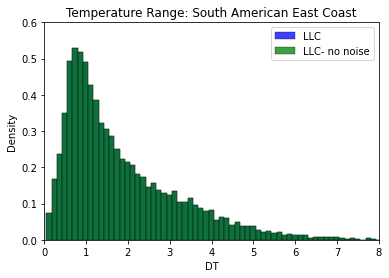

In [85]:
ax3_dt = sns.histplot(data= zone3, x='DT', color = 'b', stat = 'density', label = 'LLC')
#ax3_dt = sns.histplot(data=zone3_M, x='DT', color = 'g', stat = 'density', label = 'MODIS')
ax3_dt = sns.histplot(data=zone3_N, x='DT', color = 'g', stat = 'density', label = 'LLC- no noise')

ax3_dt.set_xlim(0., 8.)
ax3_dt.set_ylim(0., 0.6)
ax3_dt.set_title('Temperature Range: South American East Coast')
ax3_dt.legend()

#### Pick 9 random numbers

In [39]:
indices3 = random.sample( range(lowLL_zone3.shape[0]), 9)

lowLL_3 = lowLL_zone3.iloc[indices3]
highLL_3 = highLL_zone3.iloc[indices3]

# Zone 4: Off Cape Town

In [86]:
current = (llc_table.lon > 0.) & (llc_table.lon < 50.)
below_africa = (llc_table.lat > -50) & (llc_table.lat < -30)

#zone 4
zone4 = llc_table[current & below_africa]

In [87]:
current = (year_2012.lon > 0.) & (year_2012.lon < 50.)
below_africa = (year_2012.lat > -50) & (year_2012.lat < -30)

#zone 4
zone4_M = year_2012[current & below_africa]

In [88]:
current = (llc_wo_noise.lon > 0.) & (llc_wo_noise.lon < 50.)
below_africa = (llc_wo_noise.lat > -50) & (llc_wo_noise.lat < -30)

#zone 4
zone4_N = llc_wo_noise[current & below_africa]

In [89]:
#low LL
LL99 = np.percentile(zone4.LL.to_numpy(), 99)
LL1 = np.percentile(zone4.LL.to_numpy(), 1)

LL99_M = np.percentile(zone4_M.LL.to_numpy(), 99)
LL1_M = np.percentile(zone4_M.LL.to_numpy(), 1)

lowLL_zone4 = zone4[zone4.LL < LL1]

lowLL_zone4_M = zone4_M[zone4_M.LL < LL1_M]

#high LL
highLL_zone4 = zone4[zone4.LL > LL99]

highLL_zone4_M = zone4_M[zone4_M.LL > LL99_M]

In [44]:
zone4.head()

,modis_lat,modis_lon,modis_col,modis_datetime,modis_LL,modis_row,clear_fraction,mean_temperature,Tmin,Tmax,...,pp_type,pp_idx,lat,lon,row,col,datetime,filename,LL,DT
108,-31.934961,3.899274,357,2012-01-01 00:45:00,50.167908,816,0.032227,19.203171,18.174999,19.795,...,0,220694,-31.937027,3.906250,6131,1979,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,149.460693,0.611000
111,-31.903538,2.568425,261,2012-01-01 00:45:00,89.647888,838,0.047791,19.401241,18.153999,20.180,...,0,154424,-31.904465,2.572917,6133,1915,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,106.286316,0.719999
112,-31.893417,2.069860,229,2012-01-01 00:45:00,104.596741,847,0.045776,19.464567,18.153999,20.180,...,0,84146,-31.888180,2.072917,6134,1891,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,110.237915,0.787998
113,-31.864360,3.496339,325,2012-01-01 00:45:00,31.494202,816,0.025146,19.316803,18.137001,19.795,...,0,289524,-31.871891,3.489583,6135,1959,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,127.353149,0.583000
115,-31.807840,1.560660,197,2012-01-01 00:45:00,127.619751,848,0.044556,19.587460,18.880001,20.215,...,0,399301,-31.806713,1.552083,6139,1866,2012-01-01,s3://llc/ThetaUVSalt/LLC4320_2012-01-01T00_00_...,151.647522,0.632000


#### Location

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


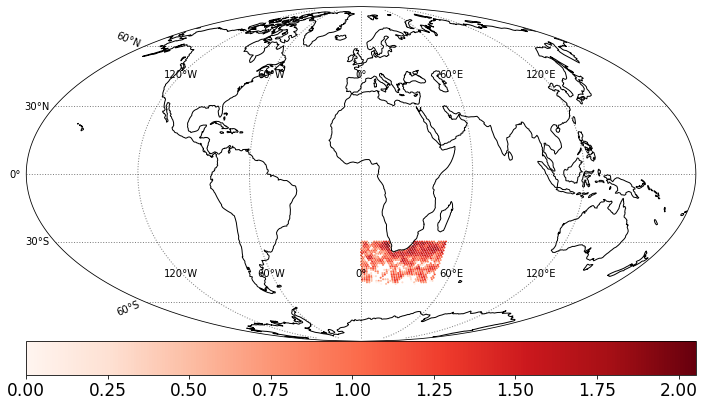

In [45]:
_ = ulmo_figs.show_spatial(zone4)

#### LL Histogram

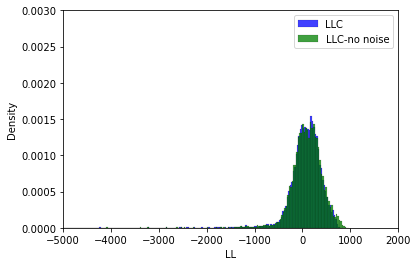

In [90]:
# Give histplot the dataframe and the column name
ax4 = sns.histplot(data= zone4, x='LL', color = 'b', stat = 'density', label = 'LLC')
#ax4 = sns.histplot(data=zone4_M, x='LL', color = 'g', stat = 'density', label = 'MODIS')
ax4 = sns.histplot(data=zone4_N, x='LL', color = 'g', stat = 'density', label = 'LLC-no noise')

ax4.set_xlim(-5000., 2000.)
ax4.set_ylim(0., 0.003)
ax4.legend()

#### Mean T Histogram

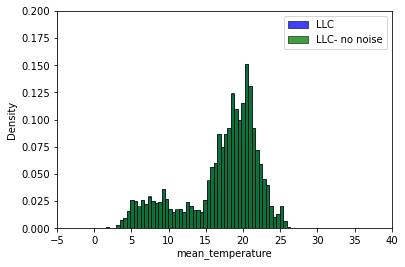

In [91]:
ax4_t = sns.histplot(data= zone4, x='mean_temperature', color = 'b', stat = 'density', label = 'LLC')
#ax4_t = sns.histplot(data=zone4_M, x='mean_temperature', color = 'g', stat = 'density', label = 'MODIS')
ax4_t = sns.histplot(data=zone4_N, x='mean_temperature', color = 'g', stat = 'density', label = 'LLC- no noise')

ax4_t.set_xlim(-5., 40.)
ax4_t.set_ylim(0., 0.2)
ax4_t.legend()

#### DT Histogram

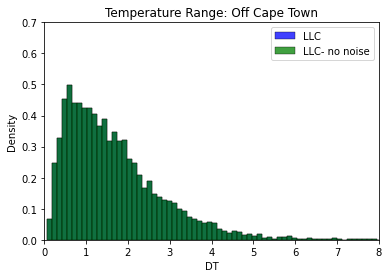

In [92]:
ax4_dt = sns.histplot(data= zone4, x='DT', color = 'b', stat = 'density', label = 'LLC')
#ax4_dt = sns.histplot(data=zone4_M, x='DT', color = 'g', stat = 'density', label = 'MODIS')
ax4_dt = sns.histplot(data=zone4_N, x='DT', color = 'g', stat = 'density', label = 'LLC- no noise')

ax4_dt.set_xlim(0., 8.)
ax4_dt.set_ylim(0., 0.7)
ax4_dt.set_title('Temperature Range: Off Cape Town')
ax4_dt.legend()

#### Plot 9 random numbers

In [49]:
indices4 = random.sample( range(lowLL_zone4.shape[0]), 9)

lowLL_4 = lowLL_zone4.iloc[indices4]
highLL_4 = highLL_zone4.iloc[indices4]

# Zone 5: Mediterranean

In [93]:
port_isra = (llc_table.lon > -5.) & (llc_table.lon < 35.)
euro_afri = (llc_table.lat > 30) & (llc_table.lat < 45)

#zone 5
zone5 = llc_table[port_isra & euro_afri]

In [94]:
port_isra = (year_2012.lon > -5.) & (year_2012.lon < 35.)
euro_afri = (year_2012.lat > 30) & (year_2012.lat < 45)

#zone 5
zone5_M = year_2012[port_isra & euro_afri]

In [95]:
port_isra = (llc_wo_noise.lon > -5.) & (llc_wo_noise.lon < 35.)
euro_afri = (llc_wo_noise.lat > 30) & (llc_wo_noise.lat < 45)

#zone 5
zone5_N = llc_wo_noise[port_isra & euro_afri]

In [78]:
#low LL
LL99 = np.percentile(zone5.LL.to_numpy(), 99)
LL1 = np.percentile(zone5.LL.to_numpy(), 1)

LL99_M = np.percentile(zone5_M.LL.to_numpy(), 99)
LL1_M = np.percentile(zone5_M.LL.to_numpy(), 1)

lowLL_zone5 = zone5[zone5.LL < LL1]

lowLL_zone5_M = zone5_M[zone5_M.LL < LL1_M]

#high LL
highLL_zone5 = zone5[zone5.LL > LL99]

highLL_zone5_M = zone5_M[zone5_M.LL > LL99_M]

#### Location

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


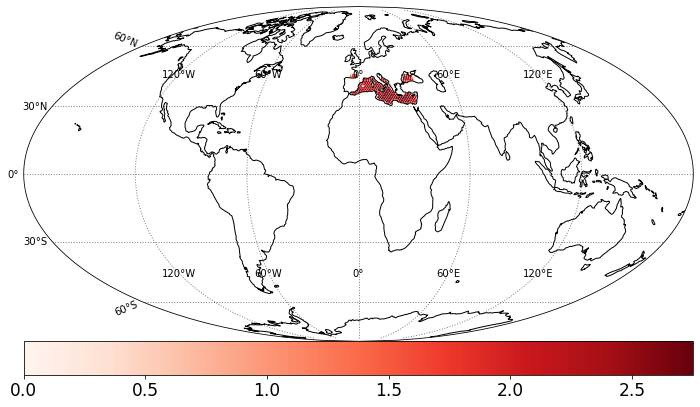

In [54]:
_ = ulmo_figs.show_spatial(zone5)

#### LL Histogram

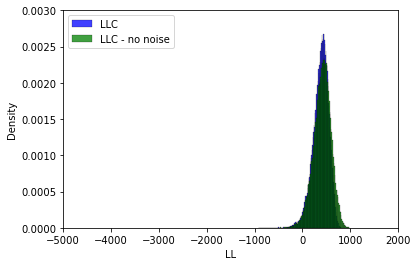

In [96]:
# Give histplot the dataframe and the column name
ax5 = sns.histplot(data= zone5, x='LL', color = 'b', stat = 'density', label = 'LLC')
#ax5 = sns.histplot(data=zone5_M, x='LL', color = 'g', stat = 'density', label = 'MODIS')
ax5 = sns.histplot(data=zone5_N, x='LL', color = 'g', stat = 'density', label = 'LLC - no noise')

ax5.set_xlim(-5000., 2000.)
ax5.set_ylim(0., 0.003)
ax5.legend()

#### Mean T Histogram

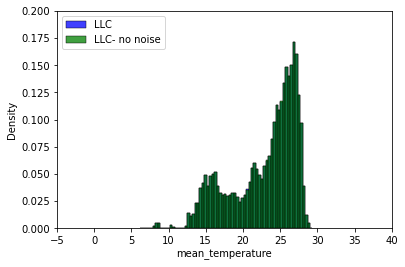

In [97]:
ax5_t = sns.histplot(data= zone5, x='mean_temperature', color = 'b', stat = 'density', label = 'LLC')
#ax5_t = sns.histplot(data=zone5_M, x='mean_temperature', color = 'g', stat = 'density', label = 'MODIS')
ax5_t = sns.histplot(data=zone5_N, x='mean_temperature', color = 'g', stat = 'density', label = 'LLC- no noise')

ax5_t.set_xlim(-5., 40.)
ax5_t.set_ylim(0., 0.2)
ax5_t.legend()

#### DT Histogram

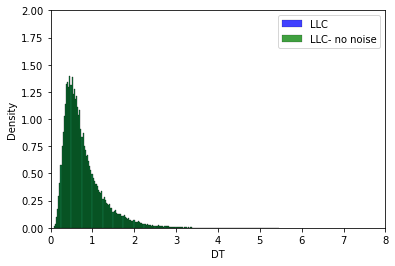

In [98]:
ax5_dt = sns.histplot(data= zone5, x='DT', color = 'b', stat = 'density', label = 'LLC')
#ax5_dt = sns.histplot(data=zone5_M, x='DT', color = 'g', stat = 'density', label = 'MODIS')
ax5_dt = sns.histplot(data=zone5_N, x='DT', color = 'g', stat = 'density', label = 'LLC- no noise')

ax5_dt.set_xlim(0., 8.)
ax5_dt.set_ylim(0., 2)
ax5_dt.legend()

#### Pick 9 random numbers

In [58]:
indices5 = random.sample( range(lowLL_zone5.shape[0]), 9)

lowLL_5 = lowLL_zone5.iloc[indices5]
highLL_5 = highLL_zone5.iloc[indices5]

# Zone 6: South 

In [104]:
below_60S = (llc_table.lat < -60)

#zone 6
zone6 = llc_table[below_60S]

In [105]:
below_60S = (mod_table.lat < -60)

#zone 6
zone6_M = mod_table[below_60S]

In [106]:
below_60S = (llc_wo_noise.lat < -60)

#zone 6
zone6_N = llc_wo_noise[below_60S]

## LL Histogram

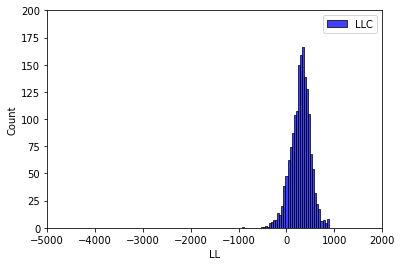

In [114]:
ax6 = sns.histplot(data= zone6, x='LL', color = 'b', stat = 'count', label = 'LLC')
#ax6 = sns.histplot(data=zone6_M, x='LL', color = 'g', stat = 'density', label = 'MODIS')
#ax6 = sns.histplot(data=zone6_N, x='LL', color = 'g', stat = 'density', label = 'LLC - no noise')

ax6.set_xlim(-5000., 2000.)
ax6.set_ylim(0., 200)
ax6.legend()

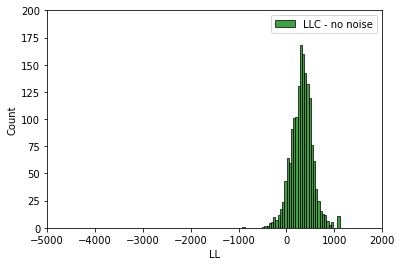

In [115]:
ax6 = sns.histplot(data=zone6_N, x='LL', color = 'g', stat = 'count', label = 'LLC - no noise')
ax6.set_xlim(-5000., 2000.)
ax6.set_ylim(0., 200)
ax6.legend()

In [108]:
zone6.shape

(1660, 27)